# Time Series Clustering with Pretrained Models





## 1. Install and Import Libraries

In [1]:
# Install required libraries
!pip install tslearn --quiet
!pip install tsfresh --quiet
!pip install yfinance --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set random seed and plotting style
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print("Base libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 13.0 MB/s eta 0:00:00
Base libraries imported successfully!


In [2]:
# Import time series specific libraries
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw, dtw
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.datasets import CachedDatasets

print("tslearn imported successfully!")

# Import tsfresh for feature extraction
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute

print("tsfresh imported successfully!")

tslearn imported successfully!
tsfresh imported successfully!


## 2. Generate Synthetic Time Series Data

In [3]:
def generate_synthetic_timeseries(n_samples_per_class=30, length=100):
    """
    Generate synthetic time series data with different patterns.

    Patterns:
    - Class 0: Sinusoidal pattern
    - Class 1: Linear trend with noise
    - Class 2: Step pattern
    - Class 3: Sawtooth pattern
    """
    np.random.seed(42)
    t = np.linspace(0, 4*np.pi, length)

    data = []
    labels = []

    # Class 0: Sinusoidal
    for i in range(n_samples_per_class):
        freq = np.random.uniform(0.8, 1.2)
        phase = np.random.uniform(0, np.pi)
        amplitude = np.random.uniform(0.8, 1.2)
        noise = np.random.normal(0, 0.1, length)
        signal = amplitude * np.sin(freq * t + phase) + noise
        data.append(signal)
        labels.append(0)

    # Class 1: Linear trend
    for i in range(n_samples_per_class):
        slope = np.random.uniform(0.3, 0.7)
        intercept = np.random.uniform(-0.5, 0.5)
        noise = np.random.normal(0, 0.2, length)
        signal = slope * np.linspace(0, 2, length) + intercept + noise
        data.append(signal)
        labels.append(1)

    # Class 2: Step pattern
    for i in range(n_samples_per_class):
        step_point = np.random.randint(30, 70)
        step_height = np.random.uniform(0.8, 1.5)
        noise = np.random.normal(0, 0.15, length)
        signal = np.concatenate([np.zeros(step_point), np.ones(length-step_point) * step_height]) + noise
        data.append(signal)
        labels.append(2)

    # Class 3: Sawtooth pattern
    for i in range(n_samples_per_class):
        period = np.random.randint(20, 35)
        noise = np.random.normal(0, 0.1, length)
        signal = (np.arange(length) % period) / period + noise
        data.append(signal)
        labels.append(3)

    return np.array(data), np.array(labels)

# Generate data
X_ts, y_ts = generate_synthetic_timeseries(n_samples_per_class=30, length=100)
print(f"Time series data shape: {X_ts.shape}")
print(f"Number of samples per class: 30")
print(f"Time series length: 100")

Time series data shape: (120, 100)
Number of samples per class: 30
Time series length: 100


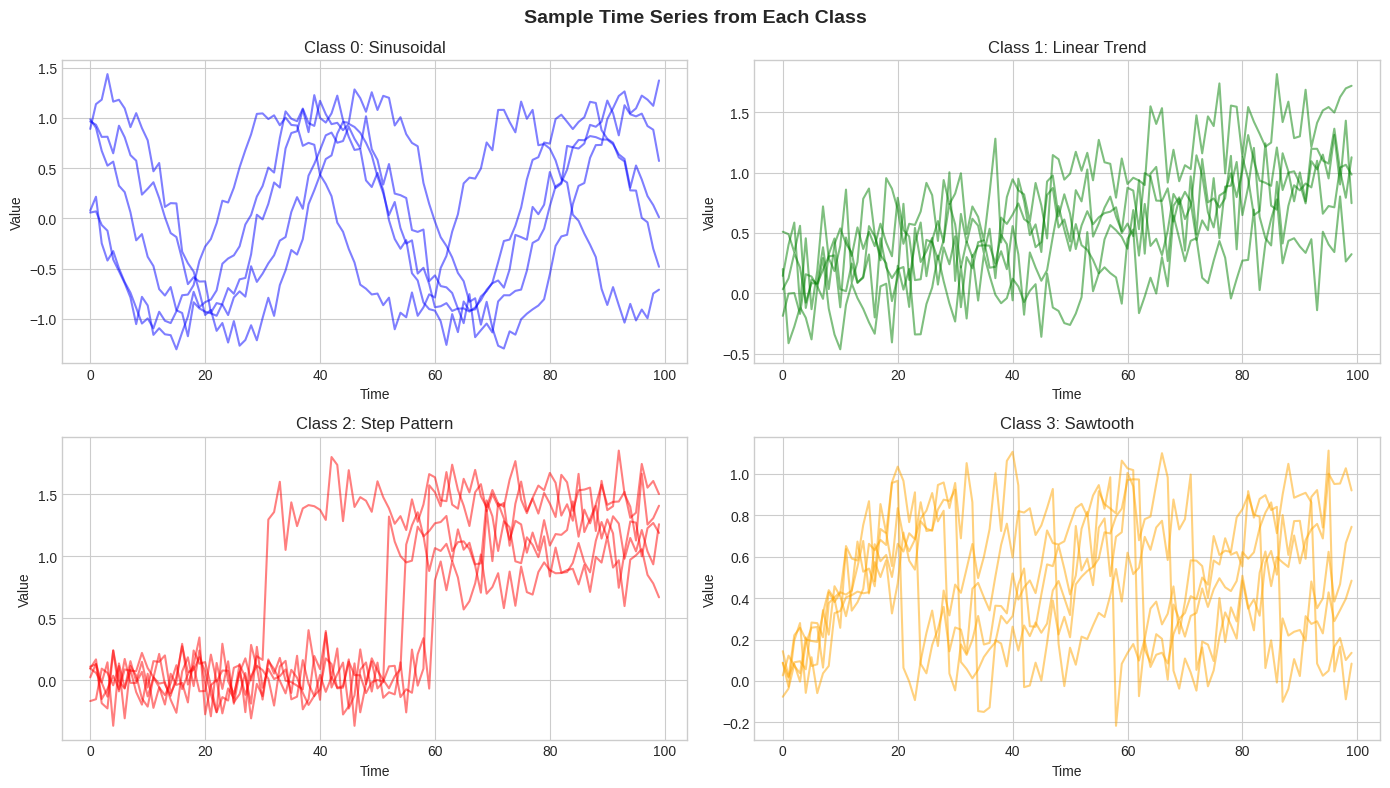

In [4]:
# Visualize sample time series from each class
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
class_names = ['Sinusoidal', 'Linear Trend', 'Step Pattern', 'Sawtooth']
colors = ['blue', 'green', 'red', 'orange']

for class_idx in range(4):
    ax = axes[class_idx // 2, class_idx % 2]
    class_mask = y_ts == class_idx

    # Plot several samples from this class
    for i, ts in enumerate(X_ts[class_mask][:5]):
        ax.plot(ts, alpha=0.5, color=colors[class_idx])

    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Class {class_idx}: {class_names[class_idx]}')

plt.suptitle('Sample Time Series from Each Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Time Series Clustering with DTW (Dynamic Time Warping)

In [5]:
# Reshape data for tslearn (n_samples, n_timestamps, n_features)
X_ts_reshaped = X_ts.reshape(X_ts.shape[0], X_ts.shape[1], 1)

# Normalize the data
scaler = TimeSeriesScalerMeanVariance()
X_ts_scaled = scaler.fit_transform(X_ts_reshaped)

print(f"Scaled data shape: {X_ts_scaled.shape}")

Scaled data shape: (120, 100, 1)


In [6]:
# Apply TimeSeriesKMeans with DTW distance
n_clusters = 4

# DTW-based K-Means
print("Training DTW K-Means (this may take a moment)...")
dtw_kmeans = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric='dtw',
    max_iter=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
labels_dtw = dtw_kmeans.fit_predict(X_ts_scaled)

# Euclidean-based K-Means for comparison
print("Training Euclidean K-Means...")
euclidean_kmeans = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric='euclidean',
    max_iter=10,
    random_state=42
)
labels_euclidean = euclidean_kmeans.fit_predict(X_ts_scaled)

# Soft-DTW K-Means
print("Training Soft-DTW K-Means...")
soft_dtw_kmeans = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric='softdtw',
    max_iter=10,
    random_state=42
)
labels_soft_dtw = soft_dtw_kmeans.fit_predict(X_ts_scaled)

print("Training complete!")

Training DTW K-Means (this may take a moment)...
Training Euclidean K-Means...
Training Soft-DTW K-Means...
Training complete!


In [7]:
# Calculate clustering quality metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Flatten for sklearn metrics
X_flat = X_ts_scaled.reshape(X_ts_scaled.shape[0], -1)

results = {
    'DTW K-Means': labels_dtw,
    'Euclidean K-Means': labels_euclidean,
    'Soft-DTW K-Means': labels_soft_dtw
}

print("Clustering Quality Metrics:")
print("="*70)

metrics_data = []
for name, labels in results.items():
    ari = adjusted_rand_score(y_ts, labels)
    nmi = normalized_mutual_info_score(y_ts, labels)
    sil = silhouette_score(X_flat, labels)

    metrics_data.append({
        'Method': name,
        'ARI': ari,
        'NMI': nmi,
        'Silhouette': sil
    })

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string(index=False))
print("="*70)

Clustering Quality Metrics:
           Method      ARI      NMI  Silhouette
      DTW K-Means 0.641699 0.808808    0.276651
Euclidean K-Means 0.484002 0.662179    0.274203
 Soft-DTW K-Means 0.636563 0.806382    0.279032


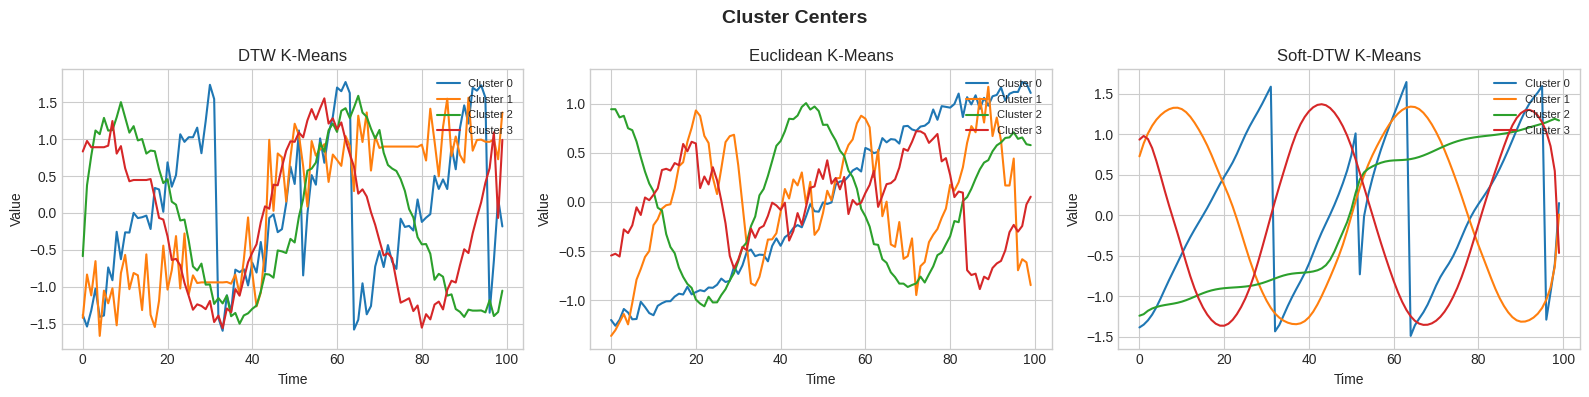

In [8]:
# Visualize cluster centers
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

cluster_models = [
    (dtw_kmeans, 'DTW K-Means'),
    (euclidean_kmeans, 'Euclidean K-Means'),
    (soft_dtw_kmeans, 'Soft-DTW K-Means')
]

for ax, (model, title) in zip(axes, cluster_models):
    for i, center in enumerate(model.cluster_centers_):
        ax.plot(center.ravel(), label=f'Cluster {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize=8)

plt.suptitle('Cluster Centers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Feature-Based Time Series Clustering with tsfresh

In [9]:
# Prepare data for tsfresh
# tsfresh expects a DataFrame with columns: id, time, value

tsfresh_data = []
for idx, ts in enumerate(X_ts):
    for t, val in enumerate(ts):
        tsfresh_data.append({'id': idx, 'time': t, 'value': val})

df_tsfresh = pd.DataFrame(tsfresh_data)
print(f"tsfresh DataFrame shape: {df_tsfresh.shape}")
print(df_tsfresh.head(10))

tsfresh DataFrame shape: (12000, 3)
   id  time     value
0   0     0  0.057341
1   0     1  0.069336
2   0     2 -0.066277
3   0     3 -0.123389
4   0     4 -0.409529
5   0     5 -0.525857
6   0     6 -0.645505
7   0     7 -0.787261
8   0     8 -1.052505
9   0     9 -0.781123


In [10]:
# Extract features using tsfresh (using MinimalFCParameters for speed)
print("Extracting features with tsfresh (this may take a moment)...")

extracted_features = extract_features(
    df_tsfresh,
    column_id='id',
    column_sort='time',
    default_fc_parameters=MinimalFCParameters(),
    disable_progressbar=True
)

# Impute missing values
extracted_features = impute(extracted_features)

print(f"Extracted features shape: {extracted_features.shape}")
print(f"\nFeature names (first 10): {list(extracted_features.columns[:10])}")

Extracting features with tsfresh (this may take a moment)...
Extracted features shape: (120, 10)

Feature names (first 10): ['value__sum_values', 'value__median', 'value__mean', 'value__length', 'value__standard_deviation', 'value__variance', 'value__root_mean_square', 'value__maximum', 'value__absolute_maximum', 'value__minimum']


In [11]:
# Apply clustering on extracted features
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(extracted_features)

# K-Means on features
kmeans_features = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_features = kmeans_features.fit_predict(X_features_scaled)

# Hierarchical clustering
hclust_features = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels_hclust = hclust_features.fit_predict(X_features_scaled)

# Evaluate
print("Feature-Based Clustering Results:")
print("="*60)

for name, labels in [('K-Means (Features)', labels_features),
                     ('Hierarchical (Features)', labels_hclust)]:
    ari = adjusted_rand_score(y_ts, labels)
    nmi = normalized_mutual_info_score(y_ts, labels)
    sil = silhouette_score(X_features_scaled, labels)
    print(f"{name:25s}: ARI={ari:.4f}, NMI={nmi:.4f}, Silhouette={sil:.4f}")

print("="*60)

Feature-Based Clustering Results:
K-Means (Features)       : ARI=0.5300, NMI=0.6116, Silhouette=0.5023
Hierarchical (Features)  : ARI=0.5477, NMI=0.6229, Silhouette=0.4811


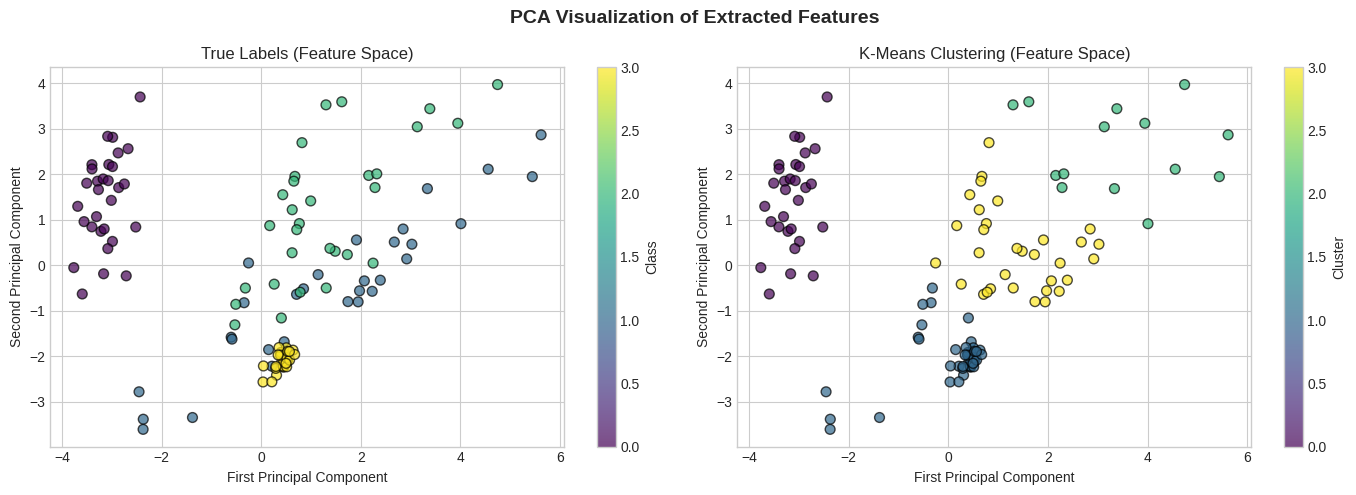

Explained variance ratio: [0.55278668 0.39074723]


In [12]:
# PCA visualization of feature space
pca = PCA(n_components=2)
X_features_pca = pca.fit_transform(X_features_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# True labels
scatter1 = axes[0].scatter(X_features_pca[:, 0], X_features_pca[:, 1],
                           c=y_ts, cmap='viridis', alpha=0.7, s=50, edgecolors='k')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('True Labels (Feature Space)')
plt.colorbar(scatter1, ax=axes[0], label='Class')

# Predicted labels
scatter2 = axes[1].scatter(X_features_pca[:, 0], X_features_pca[:, 1],
                           c=labels_features, cmap='viridis', alpha=0.7, s=50, edgecolors='k')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_title('K-Means Clustering (Feature Space)')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.suptitle('PCA Visualization of Extracted Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

## 5. Real-World Example: Stock Price Clustering

In [14]:
# Download stock data
import yfinance as yf

# List of stock tickers (diverse sectors)
tickers = [
    # Technology
    'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA',
    # Finance
    'JPM', 'BAC', 'GS', 'MS', 'WFC',
    # Healthcare
    'JNJ', 'PFE', 'UNH', 'MRK', 'ABBV',
    # Consumer
    'AMZN', 'WMT', 'HD', 'MCD', 'NKE',
    # Energy
    'XOM', 'CVX', 'COP', 'SLB', 'EOG'
]

sector_mapping = {
    'AAPL': 'Tech', 'MSFT': 'Tech', 'GOOGL': 'Tech', 'META': 'Tech', 'NVDA': 'Tech',
    'JPM': 'Finance', 'BAC': 'Finance', 'GS': 'Finance', 'MS': 'Finance', 'WFC': 'Finance',
    'JNJ': 'Healthcare', 'PFE': 'Healthcare', 'UNH': 'Healthcare', 'MRK': 'Healthcare', 'ABBV': 'Healthcare',
    'AMZN': 'Consumer', 'WMT': 'Consumer', 'HD': 'Consumer', 'MCD': 'Consumer', 'NKE': 'Consumer',
    'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy', 'SLB': 'Energy', 'EOG': 'Energy'
}

print("Downloading stock data...")

# Download historical data
stock_data = yf.download(tickers, start='2023-01-01', end='2024-01-01', progress=False)

# Get adjusted close prices
close_prices = stock_data['Adj Close']

# Drop any stocks with missing data
close_prices = close_prices.dropna(axis=1)

print(f"\nStock data shape: {close_prices.shape}")
print(f"Stocks included: {list(close_prices.columns)}")

KeyError: 'Adj Close'

In [16]:
# Calculate daily returns
returns = close_prices.pct_change().dropna()

# Normalize prices for comparison (relative to starting price)
normalized_prices = close_prices / close_prices.iloc[0] * 100

# Visualize stock prices by sector
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
sectors = ['Tech', 'Finance', 'Healthcare', 'Consumer', 'Energy']
colors_sector = {'Tech': 'blue', 'Finance': 'green', 'Healthcare': 'red',
                 'Consumer': 'orange', 'Energy': 'purple'}

for idx, sector in enumerate(sectors):
    ax = axes[idx // 3, idx % 3]
    sector_stocks = [s for s in close_prices.columns if sector_mapping.get(s) == sector]

    for stock in sector_stocks:
        ax.plot(normalized_prices[stock], label=stock, alpha=0.7)

    ax.set_xlabel('Date')
    ax.set_ylabel('Normalized Price')
    ax.set_title(f'{sector} Sector')
    ax.legend(loc='upper left', fontsize=8)
    ax.tick_params(axis='x', rotation=45)

axes[1, 2].axis('off')  # Hide empty subplot

plt.suptitle('Normalized Stock Prices by Sector', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

NameError: name 'close_prices' is not defined

In [ ]:
# Prepare stock data for clustering
X_stocks = normalized_prices.T.values  # Shape: (n_stocks, n_timestamps)
stock_names = list(normalized_prices.columns)
true_sectors = [sector_mapping.get(s, 'Unknown') for s in stock_names]

# Encode sectors for evaluation
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_sectors = le.fit_transform(true_sectors)

print(f"Stock time series shape: {X_stocks.shape}")
print(f"Sectors: {le.classes_}")

In [ ]:
# Apply clustering to stocks
# Reshape for tslearn
X_stocks_reshaped = X_stocks.reshape(X_stocks.shape[0], X_stocks.shape[1], 1)

# Normalize
scaler_stocks = TimeSeriesScalerMeanVariance()
X_stocks_scaled = scaler_stocks.fit_transform(X_stocks_reshaped)

# DTW K-Means
print("Clustering stocks with DTW K-Means...")
dtw_stock = TimeSeriesKMeans(
    n_clusters=5,  # 5 sectors
    metric='dtw',
    max_iter=10,
    random_state=42,
    n_jobs=-1
)
stock_labels_dtw = dtw_stock.fit_predict(X_stocks_scaled)

# Euclidean K-Means
euclidean_stock = TimeSeriesKMeans(
    n_clusters=5,
    metric='euclidean',
    random_state=42
)
stock_labels_euclidean = euclidean_stock.fit_predict(X_stocks_scaled)

print("Clustering complete!")

In [ ]:
# Evaluate stock clustering
print("Stock Clustering Evaluation:")
print("="*60)

X_stocks_flat = X_stocks_scaled.reshape(X_stocks_scaled.shape[0], -1)

for name, labels in [('DTW K-Means', stock_labels_dtw),
                     ('Euclidean K-Means', stock_labels_euclidean)]:
    ari = adjusted_rand_score(y_sectors, labels)
    nmi = normalized_mutual_info_score(y_sectors, labels)
    sil = silhouette_score(X_stocks_flat, labels)
    print(f"{name:20s}: ARI={ari:.4f}, NMI={nmi:.4f}, Silhouette={sil:.4f}")

print("="*60)

In [ ]:
# Visualize clustering results
results_df = pd.DataFrame({
    'Stock': stock_names,
    'True Sector': true_sectors,
    'DTW Cluster': stock_labels_dtw,
    'Euclidean Cluster': stock_labels_euclidean
})

print("Stock Clustering Results:")
print(results_df.to_string(index=False))

In [ ]:
# Create a heatmap showing cluster assignments
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix: True Sector vs DTW Cluster
from sklearn.metrics import confusion_matrix

cm_dtw = pd.crosstab(results_df['True Sector'], results_df['DTW Cluster'])
sns.heatmap(cm_dtw, annot=True, cmap='Blues', ax=axes[0], fmt='d')
axes[0].set_title('True Sector vs DTW Cluster')
axes[0].set_xlabel('DTW Cluster')
axes[0].set_ylabel('True Sector')

cm_euclidean = pd.crosstab(results_df['True Sector'], results_df['Euclidean Cluster'])
sns.heatmap(cm_euclidean, annot=True, cmap='Blues', ax=axes[1], fmt='d')
axes[1].set_title('True Sector vs Euclidean Cluster')
axes[1].set_xlabel('Euclidean Cluster')
axes[1].set_ylabel('True Sector')

plt.suptitle('Stock Sector vs Cluster Assignments', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Hierarchical Clustering with DTW Distance Matrix

In [ ]:
# Calculate DTW distance matrix for stocks
print("Calculating DTW distance matrix...")
dtw_distance_matrix = cdist_dtw(X_stocks_scaled)

print(f"Distance matrix shape: {dtw_distance_matrix.shape}")

In [17]:
# Create dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Convert to condensed distance matrix
condensed_dist = squareform(dtw_distance_matrix, checks=False)

# Hierarchical clustering
Z = linkage(condensed_dist, method='average')

# Create dendrogram
plt.figure(figsize=(16, 8))

# Color by sector
sector_colors = {'Tech': 'blue', 'Finance': 'green', 'Healthcare': 'red',
                 'Consumer': 'orange', 'Energy': 'purple'}
label_colors = [sector_colors.get(sector_mapping.get(s, 'Unknown'), 'black') for s in stock_names]

dendrogram(Z, labels=stock_names, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering of Stocks (DTW Distance)', fontsize=14, fontweight='bold')
plt.xlabel('Stock')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.show()

print("\nLegend: Blue=Tech, Green=Finance, Red=Healthcare, Orange=Consumer, Purple=Energy")

NameError: name 'dtw_distance_matrix' is not defined

## 7. Summary and Quality Metrics Comparison

In [ ]:
# Comprehensive comparison of all methods
print("="*70)
print("COMPREHENSIVE CLUSTERING QUALITY METRICS")
print("="*70)

# Synthetic data results
print("\n1. SYNTHETIC TIME SERIES DATA:")
print("-"*50)

synthetic_results = [
    ('DTW K-Means', labels_dtw),
    ('Euclidean K-Means', labels_euclidean),
    ('Soft-DTW K-Means', labels_soft_dtw),
    ('Feature K-Means', labels_features),
    ('Feature Hierarchical', labels_hclust)
]

synthetic_metrics = []
for name, labels in synthetic_results:
    ari = adjusted_rand_score(y_ts, labels)
    nmi = normalized_mutual_info_score(y_ts, labels)
    sil = silhouette_score(X_flat, labels)
    ch = calinski_harabasz_score(X_flat, labels)
    db = davies_bouldin_score(X_flat, labels)

    synthetic_metrics.append({
        'Method': name,
        'ARI': ari,
        'NMI': nmi,
        'Silhouette': sil,
        'CH Index': ch,
        'DB Index': db
    })

syn_df = pd.DataFrame(synthetic_metrics)
print(syn_df.to_string(index=False))

# Stock data results
print("\n2. STOCK TIME SERIES DATA:")
print("-"*50)

stock_results = [
    ('DTW K-Means', stock_labels_dtw),
    ('Euclidean K-Means', stock_labels_euclidean)
]

stock_metrics = []
for name, labels in stock_results:
    ari = adjusted_rand_score(y_sectors, labels)
    nmi = normalized_mutual_info_score(y_sectors, labels)
    sil = silhouette_score(X_stocks_flat, labels)

    stock_metrics.append({
        'Method': name,
        'ARI': ari,
        'NMI': nmi,
        'Silhouette': sil
    })

stock_df = pd.DataFrame(stock_metrics)
print(stock_df.to_string(index=False))

print("\n" + "="*70)

In [ ]:
print("="*70)
print("TIME SERIES CLUSTERING - SUMMARY")
print("="*70)

print("\n1. METHODS USED:")
print("   - DTW (Dynamic Time Warping) K-Means")
print("   - Euclidean K-Means")
print("   - Soft-DTW K-Means")
print("   - Feature-based clustering (tsfresh + K-Means)")
print("   - Hierarchical clustering with DTW distance")

print("\n2. KEY LIBRARIES:")
print("   - tslearn: Time series machine learning")
print("   - tsfresh: Automatic feature extraction")
print("   - yfinance: Stock data retrieval")

print("\n3. QUALITY METRICS:")
print("   - Adjusted Rand Index (ARI): Agreement with ground truth")
print("   - Normalized Mutual Information (NMI): Information shared")
print("   - Silhouette Score: Cluster cohesion and separation")
print("   - Calinski-Harabasz Index: Between/within cluster variance")
print("   - Davies-Bouldin Index: Average cluster similarity")

print("\n4. DATASETS:")
print("   - Synthetic time series (4 pattern classes)")
print("   - Real stock price data (5 sectors)")

print("\n5. KEY FINDINGS:")
best_syn = syn_df.loc[syn_df['ARI'].idxmax()]
print(f"   - Best method for synthetic data: {best_syn['Method']} (ARI: {best_syn['ARI']:.4f})")
print("   - DTW captures time warping and phase shifts")
print("   - Feature-based methods work well for distinct patterns")
print("   - Sector-based stock clustering shows correlation within industries")

print("\n" + "="*70)